In [252]:
import keras
import numpy as np
import os
import glob
import matplotlib.pyplot as plt


class ChickenDataGenerator(keras.utils.Sequence):
    def __init__(
        self,
        dataset_dir, # e.g. os.path.join(data_root, region, "train")
        batch_size,
        steps_per_epoch = None,
        shuffle=False,
        input_size=256,
        output_size=256,
        num_channels=4,
        num_classes=2,
        data_type="uint16",
    ):
        """Initialization"""
        
        self.dataset_dir = dataset_dir

        self.batch_size = batch_size

        self.input_size = input_size
        self.output_size = output_size
    
        self.num_channels = num_channels
        self.num_classes = num_classes

        self.img_names = np.array(sorted(list(glob.glob(os.path.join(self.dataset_dir, "img", "*")))))
        self.mask_names = np.array(sorted(list(glob.glob(os.path.join(self.dataset_dir, "mask", "*")))))

        if steps_per_epoch is not None:
            self.steps_per_epoch = steps_per_epoch
        else:
            self.steps_per_epoch = len(self.img_names)//batch_size # ??? probably handle last batch size    

        self.shuffle = shuffle

        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return self.steps_per_epoch

    def __getitem__(self, index):
        """Generate one batch of data"""
        indices = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        img_names = self.img_names[indices]
        mask_names = self.mask_names[indices]
        x_batch = np.zeros(
            (self.batch_size, self.input_size, self.input_size, self.num_channels),
            dtype=np.float32,
        )
        y_batch = np.zeros(
            (self.batch_size, self.output_size, self.output_size, self.num_classes),
            dtype=np.float32,
        )

        for i, (img_file, mask_file) in enumerate(zip(img_names, mask_names)):
            data = np.load(img_file).squeeze()
            data /= 255.0
            x_batch[i] = data[:,:,:self.num_channels]
            mask_data = np.load(mask_file)
            y_batch[i] = mask_data

        return x_batch, y_batch

    def on_epoch_end(self):
        self.indices = np.arange(len(self.img_names))
        if self.shuffle:
            np.random.shuffle(self.indices)

if __name__ == "__main__":
    pass


In [253]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [258]:
data_root = "../../../../data/jason/gen_data/balanced"
random_data_root = "../../../../data/jason/gen_datas/random"

region = "m_3807537_nw"

train_generator = ChickenDataGenerator(
    dataset_dir=os.path.join(data_root, region, "train"),
    batch_size=64
)   

In [259]:
test = train_generator[0]

In [260]:
img_names = train_generator.img_names
mask_names= train_generator.mask_names

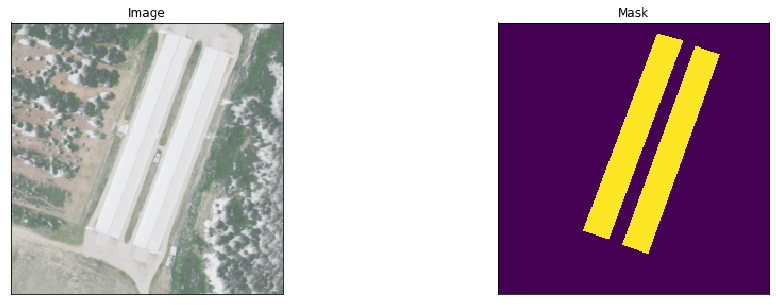

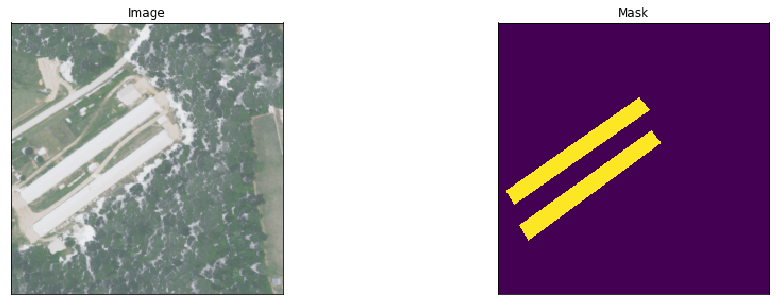

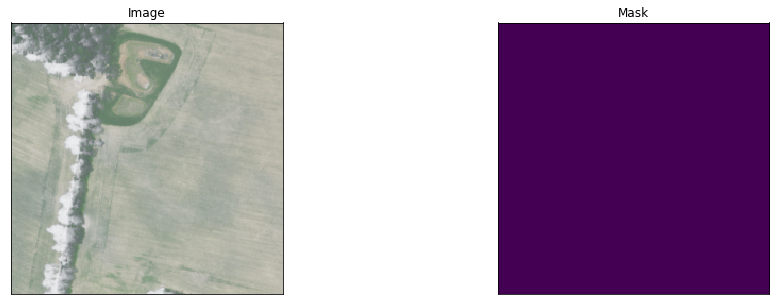

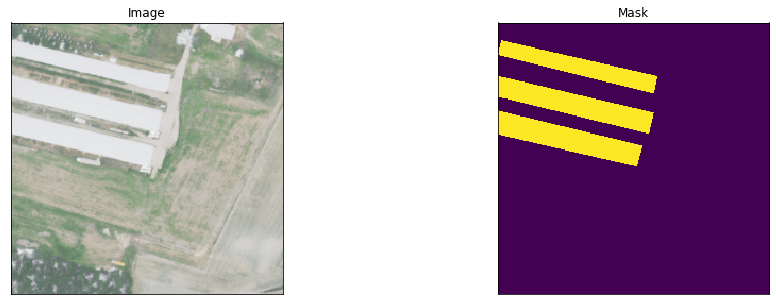

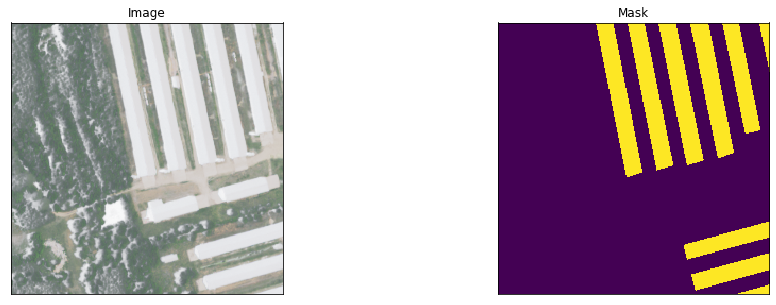

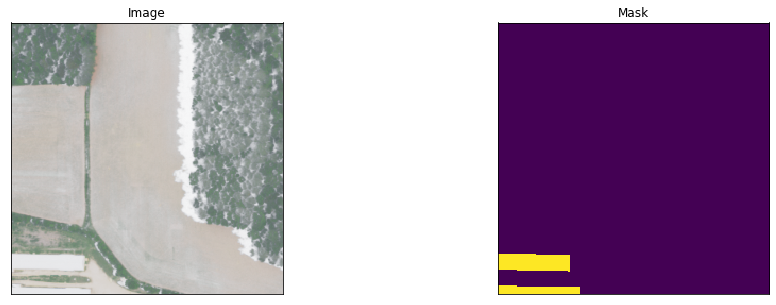

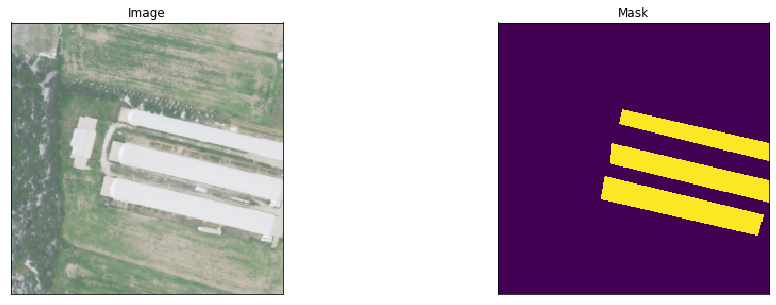

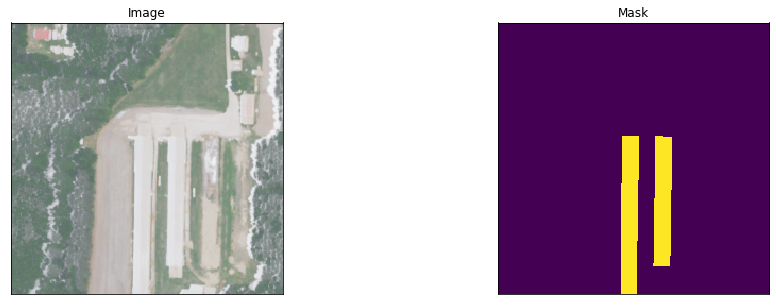

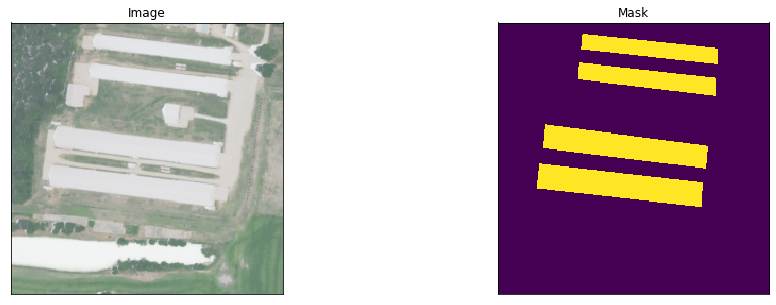

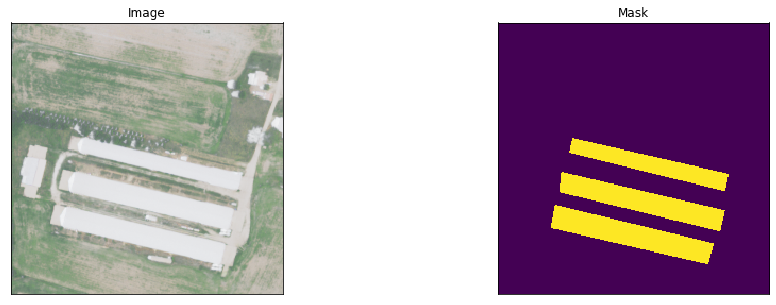

In [261]:
for i in range(10):
    visualize(image=test[0][i], mask=np.argmax(test[1][i],axis=2))

# Datagen

In [114]:
import rasterio

In [119]:
x_fns = "../../../../data/jason/datasets/md_100cm_2017/38075/"
y_fns="../binary_raster_md_tif/"
width=256
height=256
channel=4
target=2
total_num_samples=640
region="m_3807537_nw"
output_root=data_root
pct_train=0.80
pct_validation=0.15
seed=42


In [120]:
np.random.seed(seed)

# Output
output_data_dir = os.path.join(output_root, region)

for partition_name in ["train", "validation", "test"]:
    os.makedirs(os.path.join(output_data_dir, partition_name, "img"), exist_ok=True)
    os.makedirs(os.path.join(output_data_dir, partition_name, "mask"), exist_ok=True)

num_train = int(pct_train*total_num_samples)
num_validation = int(pct_validation*total_num_samples)
num_test = total_num_samples - num_train - num_validation
all_partition_names = [
    *['train' for i in range(num_train)],
    *['validation' for i in range(num_validation)],
    *['test' for i in range(num_test)]
    ]
np.random.shuffle(all_partition_names)

ground_truth_set = glob.glob(y_fns + "*")
ground_truth_set = [x for x in ground_truth_set if region in x]

count = 0
non_zero_count = 0
files_wo_chicken_houses = 0

In [181]:
# Randomly choose a file from input list
y_fn = np.random.choice(ground_truth_set)
folder_name = y_fn.split('/')[2][2:7]
filename = y_fn.split('/')[2][:26]
x_fn = x_fns + filename + ".tif"
# print(x_fn)

# Load input file
f = rasterio.open(x_fn, "r")
data = f.read().squeeze()
data = np.rollaxis(data, 0, 3)
f.close()
# print(data.shape)

# Load ground truth file
f = rasterio.open(y_fn, "r")
target = f.read().squeeze()
f.close()

# Get one-hot-encoding for ground truth
target_one_hot = keras.utils.to_categorical(target, num_classes=2)

# Used pixels
used_x = set()

# Poultry pixels
y_ind,x_ind = np.where(target==1)

### Sanity check

In [182]:
np.all(np.argmax(target_one_hot,axis=2) == target)

True

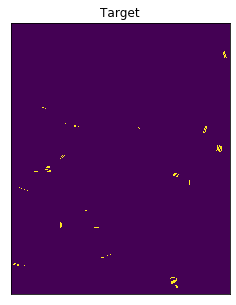

In [183]:
visualize(target=target)

In [190]:
# Randomly sample patch_size # of 256x256 patch per file

x = np.random.randint(width, data.shape[1]-width)
y = np.random.randint(height, data.shape[0]-height)

# Force to choose chicken house pixel for ~50% of data
# TODO switch to based on random coin flip
if len(x_ind) != 0 and np.random.randint(10) % 2 == 0:
    rand_index = np.random.randint(0,len(x_ind))
    x = x_ind[rand_index]
    y = y_ind[rand_index]

    temp_count = 0
    # If poultry house pixels out of bounds, random reselect pixel
    while not (x-width >= 0 and x+width < data.shape[1] and y-height >= 0 and y+height < data.shape[0]):
        rand_index = np.random.randint(0,len(x_ind))
        x = x_ind[rand_index]
        y = y_ind[rand_index]
        temp_count += 1
        if (temp_count > 5):
            x = np.random.randint(width, data.shape[1]-width)
            y = np.random.randint(height, data.shape[0]-height)

# Reselect until x is new pixel
while x in used_x:
    x = np.random.randint(width, data.shape[1]-width)
    y = np.random.randint(height, data.shape[0]-height)

used_x.add(x)

# Set up x_batch with img data at y,x coords
img = data[y-(height//2):y+(height//2), x-(width//2):x+(width//2), :].astype(np.float32)

# remove this
# x_batches[count] = img

# 256 x 256 x (4 + 2)
# data = np.random.randint(0, 255, (10,10)).astype(np.uint8)
# im = Image.fromarray(data)
# im.save('test.tif')

# TODO store img in file for count

# FOR DENSE
mask = target_one_hot[y-(height//2):y+(height//2), x-(width//2):x+(width//2)]

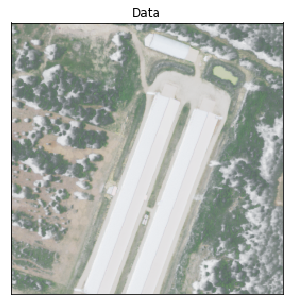

In [191]:
visualize(data=data[y-(height//2):y+(height//2), x-(width//2):x+(width//2), :])

In [195]:
temp_mask = np.argmax(mask,axis=2)

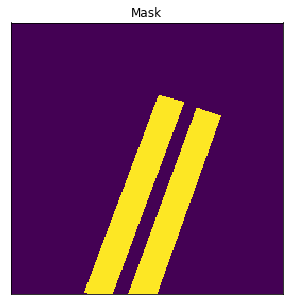

In [197]:
visualize(mask = temp_mask)